In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
import kagglehub
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR

In [ ]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),        # Random rotation within 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),      # Random horizontal flip
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Width and height shift
    transforms.RandomResizedCrop(size=32, scale=(0.9, 1.0)),  # Zoom-like effect
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize
])

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize
])

In [ ]:
path = kagglehub.dataset_download("fedesoriano/cifar10-python-in-csv")

class CIFAR10CSVDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Custom Dataset for CIFAR-10 CSV format
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

        # Separate features and labels
        # Assuming the CSV has columns: pixel values (3072 columns) + label column
        if 'label' in self.data_frame.columns:
            self.labels = self.data_frame['label'].values
            self.pixel_data = self.data_frame.drop('label', axis=1).values
        else:
            # If no 'label' column, assume last column is the label
            self.labels = self.data_frame.iloc[:, -1].values
            self.pixel_data = self.data_frame.iloc[:, :-1].values

        # Add targets attribute for compatibility with torchvision datasets
        self.targets = self.labels.tolist()

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        pixel_values = self.pixel_data[idx]

        image = pixel_values.reshape(3, 32, 32).transpose(1, 2, 0)

        image = Image.fromarray(image.astype(np.uint8))

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

import os
train_csv_path = os.path.join(path, 'train.csv')  # Adjust filename if different
test_csv_path = os.path.join(path, 'test.csv')    # Adjust filename if different

print("Files in dataset directory:", os.listdir(path))

train_dataset = CIFAR10CSVDataset(train_csv_path, transform=train_transform)
test_dataset = CIFAR10CSVDataset(test_csv_path, transform=test_transform)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Files in dataset directory: ['batches.meta', 'train.csv', 'test.csv']
Training samples: 50000
Test samples: 10000


In [ ]:
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
# test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

In [ ]:
labels = np.array(train_dataset.targets)

train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset)),
    test_size=5000,
    stratify=labels,
    random_state=42
)

train_labels = labels[train_indices]

# From the 45,000 training examples, select 5000 labeled, stratified
labeled_indices, unlabeled_indices = train_test_split(
    train_indices,
    train_size=5000,
    stratify=train_labels,
    random_state=42
)


labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)
val_dataset = Subset(train_dataset, val_indices)
val_dataset.dataset.transform = test_transform

In [ ]:
labeled_loader = DataLoader(labeled_dataset, batch_size=128, shuffle=True, num_workers=16)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=128, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        # Encoder: ResNet-18 without classifier
        resnet = models.resnet18(weights=None)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Decoder: Upsampling from 1x1 back to 32x32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), 512, 1, 1)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
def train_autoencoder(model, train_loader, val_loader, num_epochs=100):
    print("=== Pre-training Autoencoder ===")

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                output = model(data)
                val_loss += criterion(output, data).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.encoder.state_dict(), 'best_encoder.pth')

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

    # Load best encoder
    model.encoder.load_state_dict(torch.load('best_encoder.pth'))
    return model

In [ ]:
print(f"Using device: {device}")
print(f"Labeled samples: {len(labeled_dataset)}")
print(f"Unlabeled samples: {len(unlabeled_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Using device: cuda
Labeled samples: 5000
Unlabeled samples: 40000
Validation samples: 5000


In [ ]:
# Phase 1: Pre-train autoencoder on unlabeled data
autoencoder = ResNetAutoencoder().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5)

autoencoder = train_autoencoder(autoencoder, unlabeled_loader, val_loader, num_epochs=100)

=== Pre-training Autoencoder ===
Epoch [1/100], Train Loss: 0.734230, Val Loss: 0.601751
Epoch [11/100], Train Loss: 0.444391, Val Loss: 0.452219
Epoch [21/100], Train Loss: 0.416348, Val Loss: 0.421622
Epoch [31/100], Train Loss: 0.402169, Val Loss: 0.412898
Epoch [41/100], Train Loss: 0.392311, Val Loss: 0.401984
Epoch [51/100], Train Loss: 0.385126, Val Loss: 0.394332
Epoch [61/100], Train Loss: 0.379775, Val Loss: 0.393233
Epoch [71/100], Train Loss: 0.375407, Val Loss: 0.391647


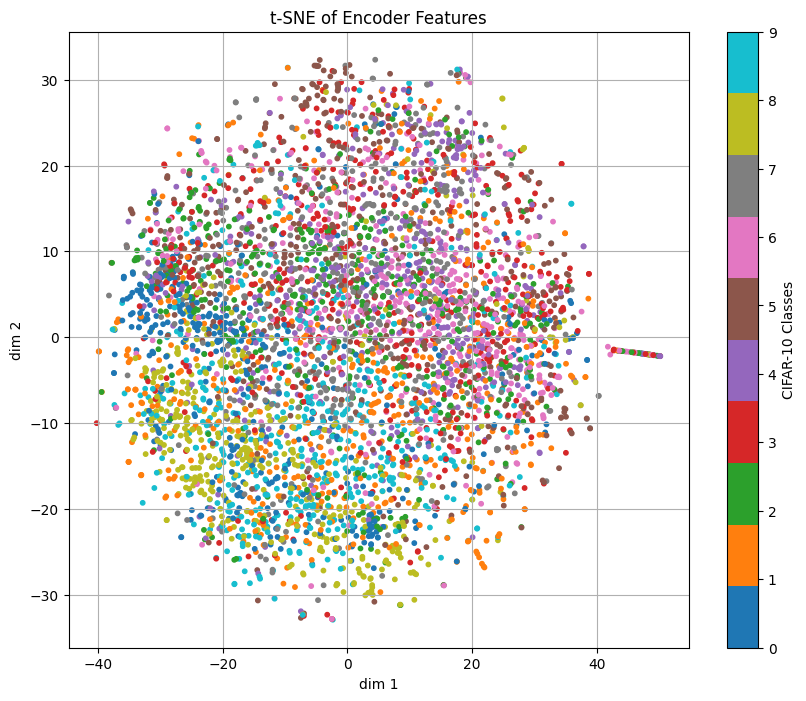

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch

# Load the best encoder
# autoencoder.encoder.load_state_dict(torch.load('best_encoder.pth'))
autoencoder.eval()

# Use a labeled loader for visualization (e.g., val_loader or a subset of test_loader)
features = []
true_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        encoded = autoencoder.encoder(imgs)
        encoded = encoded.view(encoded.size(0), -1)  # Flatten from [B, 512, 1, 1] to [B, 512]
        features.append(encoded.cpu().numpy())
        true_labels.append(labels.numpy())

features = np.concatenate(features, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=true_labels, cmap='tab10', s=10)
plt.colorbar(scatter, ticks=range(10), label='CIFAR-10 Classes')
plt.title("t-SNE of Encoder Features")
plt.xlabel("dim 1")
plt.ylabel("dim 2")
plt.grid(True)
plt.show()

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_classes=10, pretrained_encoder=None):
        super(Classifier, self).__init__()
        self.encoder = pretrained_encoder
        for param in self.encoder.parameters():
              param.requires_grad = True

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        return output

In [ ]:
def fine_tuning(model, train_loader, val_loader, num_epochs=50):
    print("=== Fine-tuning Classifier ===")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_classifier.pth')
        else:
            patience_counter += 1

        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        if patience_counter >= 15:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load('best_classifier.pth'))
    return model, best_val_acc

In [ ]:
# encoder = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-1]).to(device)
# encoder.load_state_dict(torch.load('best_encoder.pth'))

In [ ]:
pretrained_classifier = Classifier(
    num_classes=10,
    pretrained_encoder=autoencoder.encoder
).to(device)

# Phase 3: Fine-tune classifier on labeled data
pretrained_classifier, best_val_acc = fine_tuning(
    pretrained_classifier, labeled_loader, val_loader,
    num_epochs=50
)

=== Fine-tuning Classifier ===
Epoch [1/50], Train Acc: 31.78%, Val Acc: 42.94%
Epoch [6/50], Train Acc: 83.32%, Val Acc: 52.54%
Epoch [11/50], Train Acc: 97.90%, Val Acc: 52.48%
Epoch [16/50], Train Acc: 99.92%, Val Acc: 52.58%
Epoch [21/50], Train Acc: 99.62%, Val Acc: 52.72%
Epoch [26/50], Train Acc: 99.84%, Val Acc: 52.18%
Early stopping at epoch 30


In [ ]:
best_val_acc

55.02

In [ ]:
pretrained_classifier.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()

    test_acc = 100. * test_correct / test_total
    return test_acc

In [ ]:
evaluate_model(pretrained_classifier, test_loader)

53.7

In [ ]:
from collections import Counter
labels = [unlabeled_dataset.dataset.targets[i] for i in unlabeled_dataset.indices]
label_counts = Counter(labels)
total = sum(label_counts.values())
proportions = {cls: count / total for cls, count in label_counts.items()}

In [ ]:
proportions

{6: 0.1,
 0: 0.1,
 2: 0.1,
 5: 0.1,
 8: 0.1,
 1: 0.1,
 7: 0.1,
 4: 0.1,
 9: 0.1,
 3: 0.1}

In [ ]:
labels = [label for _, label in unlabeled_dataset]
num_classes = len(set(labels))
print(num_classes)

10


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply transforms
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

labels = np.array(train_dataset.targets)

# Split training data: 45k train, 5k validation
train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset)),
    test_size=5000,
    stratify=labels,
    random_state=42
)

train_labels = labels[train_indices]

# From 45k training: 1k labeled, 44k unlabeled
labeled_indices, unlabeled_indices = train_test_split(
    train_indices,
    train_size=5000,
    stratify=train_labels,
    random_state=42
)

# Create datasets
labeled_dataset = Subset(train_dataset, labeled_indices)
unlabeled_dataset = Subset(train_dataset, unlabeled_indices)
val_dataset = Subset(train_dataset, val_indices)

val_dataset.dataset.transform = test_transform
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=16)

# Data loaders
labeled_loader = DataLoader(labeled_dataset, batch_size=256, shuffle=True, num_workers=16)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=256, shuffle=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=16)

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        # Encoder: ResNet-18 without classifier
        resnet = models.resnet18(weights="IMAGENET1K_V1")
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Decoder: Upsampling from 1x1 back to 32x32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(encoded.size(0), 512, 1, 1)
        decoded = self.decoder(encoded)
        return decoded

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=10, pretrained_encoder=None):
        super(ResNetClassifier, self).__init__()

        if pretrained_encoder is not None:
            # Use pre-trained encoder
            self.encoder = pretrained_encoder
            # Freeze encoder initially (optional)
            for param in self.encoder.parameters():
                param.requires_grad = False
        else:
            # Fresh ResNet encoder
            resnet = models.resnet18(weights="IMAGENET1K_V1")
            self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0), -1)
        output = self.classifier(features)
        return output

    def unfreeze_encoder(self):
        """Unfreeze encoder for fine-tuning"""
        for param in self.encoder.parameters():
            param.requires_grad = True

def train_autoencoder(model, train_loader, val_loader, num_epochs=100):
    """Pre-training phase: Train autoencoder on unlabeled data"""
    print("=== Pre-training Autoencoder ===")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                output = model(data)
                val_loss += criterion(output, data).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.encoder.state_dict(), 'best_encoder.pth')
        else:
            patience_counter += 1

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

        # Early stopping
        if patience_counter >= 20:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best encoder
    model.encoder.load_state_dict(torch.load('best_encoder.pth'))
    return model

def train_classifier(model, train_loader, val_loader, num_epochs=50, unfreeze_after=10):
    """Fine-tuning phase: Train classifier on labeled data"""
    print("=== Fine-tuning Classifier ===")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Added weight decay
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        if epoch == unfreeze_after:
            print(f"Unfreezing encoder at epoch {epoch+1}")
            model.unfreeze_encoder()
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.0005  # Slightly higher LR for fine-tuning

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_classifier.pth')
        else:
            patience_counter += 1

        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        if patience_counter >= 15:
            print(f"Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load('best_classifier.pth'))
    return model, best_val_acc

def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()

    test_acc = 100. * test_correct / test_total
    return test_acc


print(f"Using device: {device}")
print(f"Labeled samples: {len(labeled_dataset)}")
print(f"Unlabeled samples: {len(unlabeled_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

pretrained_classifier = ResNetClassifier(
    num_classes=10,
).to(device)

pretrained_classifier, best_val_acc = train_classifier(
    pretrained_classifier, labeled_loader, val_loader,
    num_epochs=50, unfreeze_after=0
)

test_acc_pretrained = evaluate_model(pretrained_classifier, test_loader)

print(f"Baseline Model - Best Val Acc: {best_val_acc:.2f}%, Test Acc: {test_acc_pretrained:.2f}%")

Using device: cuda
Labeled samples: 5000
Unlabeled samples: 40000
Validation samples: 5000
=== Fine-tuning Classifier ===
Unfreezing encoder at epoch 1
Epoch [1/50], Train Acc: 35.30%, Val Acc: 50.64%
Epoch [6/50], Train Acc: 97.42%, Val Acc: 67.78%
Epoch [11/50], Train Acc: 99.58%, Val Acc: 69.68%
Epoch [16/50], Train Acc: 99.94%, Val Acc: 70.18%
Epoch [21/50], Train Acc: 99.98%, Val Acc: 71.04%
Epoch [26/50], Train Acc: 99.98%, Val Acc: 71.10%
Epoch [31/50], Train Acc: 100.00%, Val Acc: 71.18%
Epoch [36/50], Train Acc: 100.00%, Val Acc: 71.22%
Epoch [41/50], Train Acc: 100.00%, Val Acc: 70.84%
Epoch [46/50], Train Acc: 100.00%, Val Acc: 70.74%
Baseline Model - Best Val Acc: 71.22%, Test Acc: 70.35%
